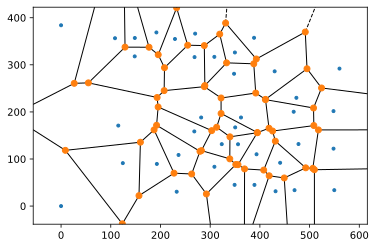

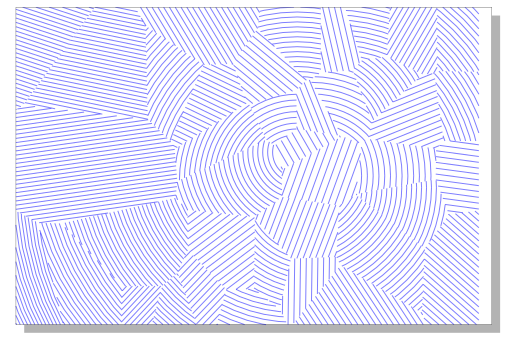

In [204]:
# coding=utf-8
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
import math
from math import atan2, degrees
from scipy.spatial import Voronoi, voronoi_plot_2d
#from shapely.geometry import Polygon

import shapely.affinity as affinity
import shapely.geometry as geo
import shapely.ops as ops
import vsketch
from sklearn.neighbors import NearestNeighbors

vsk = vsketch.Vsketch()
vsk.size("6x4in", center=False)
vsk.penWidth("0.4mm")

DISPLAY_RATIO = 1.5
W = vsk.width
H = vsk.height

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def generate_voroni_polys(points, iterations):
    step = points

    for i in range(iterations):
        polys = voroni_iteration(step)
        step = list(map(lambda p: (p.centroid.x, p.centroid.y), polys))

    return polys

def voroni_iteration(points) -> list[geo.Polygon]:
    # compute Voronoi tesselation
    vor = Voronoi(points)
    voronoi_plot_2d(vor)

    # plot
    regions, vertices = voronoi_finite_polygons_2d(vor)

    min_x = vor.min_bound[0] - 0.1
    max_x = vor.max_bound[0] + 0.1
    min_y = vor.min_bound[1] - 0.1
    max_y = vor.max_bound[1] + 0.1

    mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
    bounded_vertices = np.max((vertices, mins), axis=0)
    maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
    bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

    box = geo.Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])
    outpolys = []

    for region in regions:
        polygon = vertices[region]
        # Clipping polygon
        poly = geo.Polygon(polygon)
        poly = poly.intersection(box)
        clipped = geo.Polygon([p for p in poly.exterior.coords])

        outpolys.append(clipped)

    return outpolys
    

def distribute_points(heuristic):
    return heuristic()

def random_point_heuristic():
    points = np.random.random((80, 2))
    return list(map(lambda p: np.multiply(p, [W, H]), points))

def point_distance(a, b):
    return math.sqrt(math.pow(a[0] - b[0], 2) + math.pow(a[1] - b[1], 2))

def horizon_point_heuristic():
    points = [(0,0), (0,H)]
    center = (W * 0.75, H * 0.5)

    step = 40
    x = step
    y = step

    while True:
        if y > H:
            break

        p = (x, y)
        d = math.fabs(p[0] - center[0]) / 600
        d = 1 - min(d, 1)
        r = np.random.rand()

        #print(f"{p}: {d} -> {r}")

        if r < d * 0.45:
            normal = random_offset_vector(p, (step * 0.3, step * 0.3))
            points.append((p[0] + normal[0], p[1] + normal[1]))

        x += step

        if x > W:
            x = step
            y += step

    return points

def line_density_step(distance):
    min = vsk.strokePenWidth + 2
    return int(np.interp(distance, [0,500], [8, min]))

def random_offset_vector(uv: Tuple[float, float], range: Tuple[float, float]):
    noise = vsk.noise(uv[0], uv[1])
    angle = np.interp(noise, [0, 1], [0, 6.28])
    return (math.cos(angle) * range[0], math.sin(angle) * range[1])

last = 0
def pick_fill_shape(polygon: geo.Polygon, center: geo.Point):
    global last
    noiseScale = 20
    noise = vsk.noise(polygon.centroid.x * noiseScale, polygon.centroid.y * noiseScale)

    if last == 0:
    #if noise >= 0.5:
        last = 1
        #vsk.stroke(1)
        return build_linear_fill_shape(polygon, center, True)
    else:
        last = 0
        #vsk.stroke(2)
        return build_radial_fill_shape(polygon, center)

def build_linear_fill_shape(polygon: geo.Polygon, center: geo.Point, flip = False):
    lines = []
    centroid = polygon.centroid
    delta = geo.Point(centroid.x - center.x, centroid.y - center.y)
    
    # calculate line rotation
    angle = degrees(atan2(delta.y, delta.x))
    noise = vsk.noise(centroid.x, centroid.y)
    noise = np.interp(noise, [0, 1], [-50, 50])
    angle += noise

    if flip:
        angle += 90

    #angle = 90

    # calculate line density
    distance = math.dist([delta.x, delta.y], [0,0])
    step = line_density_step(distance - 50)

    (startX, startY, endX, endY) = polygon.bounds

    for x in np.arange(startX - (endY - startY), endX + (endY - startY), step=step):
        line = geo.LineString([(x, -H / 2), (x, H * 2)])
        line = affinity.rotate(line, angle, (centroid.x, centroid.y))
        lines.append(line)

    return geo.MultiLineString(lines)

def build_radial_fill_shape(polygon: geo.Polygon, center: geo.Point):
    lines = []
    centroid = polygon.centroid
    delta = geo.Point(centroid.x - center.x, centroid.y - center.y)
    distance = math.dist([delta.x, delta.y], [0,0])

    normal = random_offset_vector((centroid.x, centroid.y), (40, 30))
    focus = (center.x + normal[0], center.y + normal[1])

    # calculate line density
    step = line_density_step(distance)

    for x in np.arange(start=2, stop=600, step=step):
        circle = geo.Point(focus).buffer(x)
        lines.append(list(circle.exterior.coords))

    return geo.MultiLineString(lines)

def display(sketch):
    return sketch.display("matplotlib", fig_size=(6*DISPLAY_RATIO,4*DISPLAY_RATIO))


#np.random.seed(8675309)
np.random.seed(24601)
#np.random.seed(69420)
#np.random.seed(12161984)

# make up data points
#points = distribute_points(random_point_heuristic)
points = distribute_points(horizon_point_heuristic)
center = geo.Point(W - 200, H / 2)
polygons = generate_voroni_polys(points, 1)

for poly in polygons:
    fill = pick_fill_shape(poly, center)
    masked = fill.intersection(poly)

    vsk.noFill()
    vsk.geometry(masked)

display(vsk)